📉 Customer Churn Rate: 50.0%
📈 Complaint Surge Rate:
MONTH
NaT    12
dtype: int64


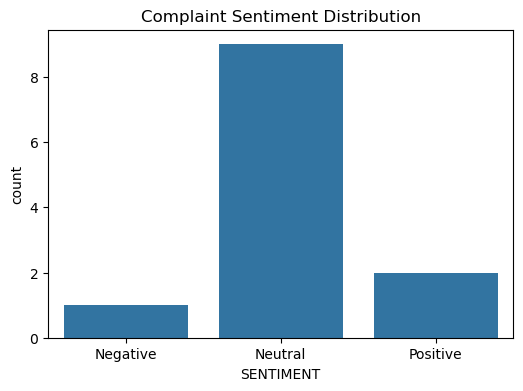

🔹 Top Complaint Categories:
CLUSTER
0    Speed and Service | Comcast not working and no...
1    Comcast Cable Internet Speeds | Comcast Impose...
2    Payment disappear - service got disconnected |...
3        YAHOO FAILURE TO RESTORE EMAIL SEARCH FEATURE
4    ISP Charging for arbitrary data limits with ov...
Name: COMPLAINT_TEXT, dtype: object


NotFound: 404 models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from textblob import TextBlob
from sklearn.metrics import silhouette_score
import google.generativeai as genai
import os

# Load Data
data = pd.read_csv("Complaints-Comp.csv")

# Standardize column names
data.columns = data.columns.str.strip()

# Rename columns for easier access
data.rename(columns={"Ticket #": "TICKET_ID", "Customer Complaint": "COMPLAINT_TEXT", "Date": "DATE",
                      "Status": "STATUS", "Received Via": "RECEIVED_VIA", "City": "CITY", "State": "STATE"}, inplace=True)

# Convert DATE column
data['DATE'] = pd.to_datetime(data['DATE'], format="%Y-%m-%d", errors='coerce')

# Compute Resolution Time
if 'DATE' in data.columns:
    today = pd.to_datetime('today')
    data['RESOLUTION_TIME'] = (today - data['DATE']).dt.days
    data['RESOLUTION_TIME'] = data['RESOLUTION_TIME'].fillna(0).astype(int)  # Fix inplace warning

# Function to calculate churn rate
def calculate_churn_rate(data):
    churned = data[data['STATUS'].str.contains("Closed", na=False)]
    return round((len(churned) / len(data)) * 100, 2) if len(data) > 0 else 0

# Function to calculate complaint surge rate over time
def calculate_surge_rate(data):
    if 'DATE' in data.columns:
        data['MONTH'] = data['DATE'].dt.to_period('M').astype(str)  # Convert to string to avoid dtype issues
        return data.groupby('MONTH').size()
    return pd.Series(dtype=int)

churn_rate = calculate_churn_rate(data)
surge_rate = calculate_surge_rate(data)

print(f"📉 Customer Churn Rate: {churn_rate}%")
print("📈 Complaint Surge Rate:")
print(surge_rate)

# Sentiment Analysis for Complaint Prioritization
def analyze_sentiment(text):
    if pd.isna(text):
        return "Neutral"
    sentiment = TextBlob(str(text)).sentiment.polarity
    if sentiment > 0.1:
        return "Positive"
    elif sentiment < -0.1:
        return "Negative"
    return "Neutral"

data['SENTIMENT'] = data['COMPLAINT_TEXT'].apply(analyze_sentiment)

# Visualizing Sentiment Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=data['SENTIMENT'], order=['Negative', 'Neutral', 'Positive'])
plt.title("Complaint Sentiment Distribution")
plt.show()

# Complaint Clustering
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X = vectorizer.fit_transform(data['COMPLAINT_TEXT'].astype(str))

kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)  # Fix warning
data['CLUSTER'] = kmeans.fit_predict(X)

print("🔹 Top Complaint Categories:")
print(data.groupby('CLUSTER')['COMPLAINT_TEXT'].apply(lambda x: ' | '.join(x[:3])))


# AI-based Recommendation using Gemini AI (Google)
os.environ["GOOGLE_API_KEY"] = "Enter your API Key"
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

def get_ai_recommendation(complaint_text):
    if not complaint_text or pd.isna(complaint_text):
        return "No complaint provided."
    model = genai.GenerativeModel("gemini-pro")
    prompt = f"Suggest an action to resolve this telecom complaint: {complaint_text}"
    response = model.generate_content(prompt)
    return response.text if response else "No recommendation available."

# Generate AI recommendations for each complaint
data['AI_RECOMMENDATION'] = data['COMPLAINT_TEXT'].apply(get_ai_recommendation)

print("🔍 Sample AI Recommendations:")
print(data[['COMPLAINT_TEXT', 'AI_RECOMMENDATION']].head(5))

# AI Insights: How to Reduce Complaint Surges
def get_ai_insights(data):
    all_complaints = " ".join(data['COMPLAINT_TEXT'].dropna().astype(str)[:50])  # Sample 50 complaints for insights
    model = genai.GenerativeModel("gemini-pro")
    prompt = f"Analyze these telecom complaints and provide strategic actions to reduce future complaint surges: {all_complaints}"
    response = model.generate_content(prompt)
    return response.text if response else "No insights available."

ai_insights = get_ai_insights(data)
print("\n📌 AI-Generated Insights to Reduce Customer Complaint Surges:\n")
print(ai_insights)

# Priority Assignment based on Resolution Time & Sentiment
def assign_priority(row):
    if row['RESOLUTION_TIME'] > 30 or row['SENTIMENT'] == 'Negative':
        return 'High'
    elif row['RESOLUTION_TIME'] > 10:
        return 'Medium'
    return 'Low'

data['PRIORITY'] = data.apply(assign_priority, axis=1)

# Display insights
print(data[['SENTIMENT', 'RESOLUTION_TIME', 'PRIORITY']].head())

# Save processed data
data.to_csv("Processed_Complaints.csv", index=False)

# Model Evaluation
# -------------------------------

# 1. **Evaluate K-Means Clustering**
silhouette_avg = silhouette_score(X, data['CLUSTER'])
inertia = kmeans.inertia_

print(f"\n📊 **K-Means Model Evaluation:**")
print(f"✔ Silhouette Score: {silhouette_avg:.4f} (Higher is better, max 1)")
print(f"✔ Inertia: {inertia:.4f} (Lower is better)")

# 2. **Evaluate Sentiment Analysis**
sentiment_counts = data['SENTIMENT'].value_counts(normalize=True) * 100
print("\n📊 **Sentiment Analysis Distribution (%):**")
print(sentiment_counts)

# If you have actual labeled sentiment data, you can compare:
# accuracy = (data['SENTIMENT'] == data['ACTUAL_LABEL']).mean() * 100
# print(f"✔ Sentiment Model Accuracy: {accuracy:.2f}% (based on labeled data)")

# 3. **Check AI Recommendation Coverage**
ai_recommendation_coverage = data['AI_RECOMMENDATION'].apply(lambda x: x != "No recommendation available.").mean() * 100
print(f"\n📊 **AI Recommendation Coverage:** {ai_recommendation_coverage:.2f}% of complaints received an AI-based resolution.")
